In [1]:
import pandas as pd

# Analyzing Psyreg

Our research questions:

1. Are we able to find any professionals currently active professionals with revoked license?
2. Are we able to identify individuals in the phone book which claim to be professionals but do not appear in the registry?
3. Are there professionals practicing in a Canton for which they do not possess authorization?

## 1. Are we able to find any professionals currently active professionals with revoked license?

The first question is easily answered by loading the dataset from source 2 and checking the binary variables set up for this use case.

### Load data

In [2]:
df = pd.read_csv('data/psyreg_details_stage3.csv', parse_dates=['date', 'limited'])
df.head()

,profession,professionId,canton,cantonId,legalBasis,state,stateId,date,limited,therapist_id,...,city,practiceCompanyName,addition1,addition2,streetWithNumber,phoneNumber,email,license_widthdrawn,license_for_x_years,license_year_issued
0,Federal recognized psychotherapist,54002,Neuenburg,11013,Authorisation under cantonal law before PsyG,Granted,53001,2008-04-11 00:00:00+00:00,NaT,28582,...,La Chaux-de-Fonds,-,NaN,NaN,Rue de la Promenade 4,079 761 31 55,NaN,False,15,2008
1,Federal recognized psychotherapist,54002,Waadt,11025,Authorisation according to Art. 24 PsyG,Granted,53001,2016-05-11 00:00:00+00:00,NaT,95003,...,Lausanne,Mme Stéphanie Cornut,NaN,NaN,Rue Neuve 11,NaN,NaN,False,7,2016
2,Federal recognized psychotherapist,54002,Freiburg,11007,Authorisation according to Art. 24 PsyG,Granted,53001,2018-11-21 00:00:00+00:00,NaT,110055,...,Romont,PsyCoherence,NaN,NaN,En Bouley 42,NaN,NaN,False,4,2018
3,Federal recognized psychotherapist,54002,Zürich,11020,Authorisation under cantonal law before PsyG,Granted,53001,1999-08-06 00:00:00+00:00,2027-01-24 00:00:00+00:00,100246,...,Zürich,Psychotherapeutische Praxis,NaN,NaN,Mühlebachstrasse 77,NaN,bea.kellermeyer@gmail.com,False,23,1999
4,Federal recognized psychotherapist,54002,Tessin,11024,Authorisation under cantonal law before PsyG,Granted,53001,1989-05-12 00:00:00+00:00,2024-10-26 00:00:00+00:00,99639,...,Bellinzona,Ambulatorio,NaN,NaN,Vicolo Cracco 26,NaN,NaN,False,34,1989


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   profession           7430 non-null   object             
 1   professionId         7430 non-null   int64              
 2   canton               7430 non-null   object             
 3   cantonId             7430 non-null   int64              
 4   legalBasis           7430 non-null   object             
 5   state                7430 non-null   object             
 6   stateId              7430 non-null   int64              
 7   date                 7430 non-null   datetime64[ns, UTC]
 8   limited              2612 non-null   datetime64[ns, UTC]
 9   therapist_id         7430 non-null   int64              
 10  name                 7430 non-null   object             
 11  firstName            7430 non-null   object             
 12  zipCity             

In [4]:
therapist_ids = df[df.license_widthdrawn].therapist_id.values

df_withdrawn = df[df.therapist_id.isin(therapist_ids)]
df_withdrawn

,profession,professionId,canton,cantonId,legalBasis,state,stateId,date,limited,therapist_id,...,city,practiceCompanyName,addition1,addition2,streetWithNumber,phoneNumber,email,license_widthdrawn,license_for_x_years,license_year_issued
4670,Federal recognized psychotherapist,54002,Zürich,11020,Authorisation under cantonal law before PsyG,"No licence, licence withdrawn",53002,2018-06-27 00:00:00+00:00,NaT,98991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4,2018
4802,Psychotherapist,54007,Bern,11006,Authorisation under cantonal law before PsyG,"No licence, licence withdrawn",53002,2015-09-21 00:00:00+00:00,NaT,114459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7,2015
4803,Psychotherapist,54007,Freiburg,11007,Authorisation under cantonal law before PsyG,Granted,53001,2010-03-26 00:00:00+00:00,NaT,114459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,13,2010
7166,Federal recognized psychotherapist,54002,Zürich,11020,Authorisation according to Art. 24 PsyG,"No licence, licence withdrawn",53002,2021-02-02 00:00:00+00:00,NaT,95812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2,2021


In [5]:
# links to inspect by hand
BASE_URL = 'https://www.psyreg.admin.ch/psyreg/person/{}'

for therapist_id in therapist_ids:
    print(BASE_URL.format(therapist_id))

https://www.psyreg.admin.ch/psyreg/person/98991
https://www.psyreg.admin.ch/psyreg/person/114459
https://www.psyreg.admin.ch/psyreg/person/95812


There are __3 therapists__ with revoked licence.

## 2. Are we able to identify individuals in the phone book which claim to be professionals but do not appear in the registry?

In [6]:
df_phonebk = pd.read_csv('data/searchCH_3transfer.csv')
df_phonebk

,permission_therapist_id,filename,work_tel_searchCH,home_tel_searchCH,scrape_name_searchCH1,scrape_name_searchCH2,work_address_searchCH,home_address_searchCH,note_searchCH,scrape_url,url_searchCH,org_searchCH,role_searchCH,rev_searchCH
0,100022,100022__Follath__Liliane.vcf,4.144382e+10,NaN,"Follath\, Liliane",Follath;Liliane;;;,"Gloriastrasse 68\nZürich, 8044\nSchweiz","Gloriastrasse 68\nZürich, 8044\nSchweiz",lic. phil. Psychologin\nAdresse auf der Schwei...,https://tel.search.ch/?was=Liliane%20Follath&w...,http://tel.search.ch/zuerich/gloriastrasse-68/...,NaN,NaN,2023-05-18T16\:59\:38Z
1,100023,100023__Dommen__Alessandra.vcf,4.158360e+10,4.158361e+10,Arud Zentrum für Suchtmedizin,;;;;,"Schützengasse 31\nZürich, 8001\nSchweiz","Schützengasse 31\nZürich, 8001\nSchweiz","Adresse auf der Schweizer Karte\: 682986,247921",https://tel.search.ch/zuerich/schuetzengasse-3...,http://www.arud.ch/,Arud Zentrum für Suchtmedizin,Suchttherapie,2023-05-18T16\:59\:40Z
2,100024,100024__Rechsteiner-Schuler__Nicole.vcf,4.180081e+10,4.158218e+10,AXA Versicherungen AG,;;;;,"Pionierstrasse 3\nWinterthur, 8400\nSchweiz","Pionierstrasse 3\nWinterthur, 8400\nSchweiz","Adresse auf der Schweizer Karte\: Winterthur,P...",https://tel.search.ch/winterthur/pionierstrass...,http://www.axa.ch/,AXA Versicherungen AG,Versicherung,2023-05-18T16\:59\:50Z
3,100025,100025__Whinyates__Katherina.vcf,4.179102e+10,NaN,Praxis für Psychotherapie,;;;;,"Spalenberg 62\nBasel, 4051\nSchweiz","Spalenberg 62\nBasel, 4051\nSchweiz","lic.phil.I, eidg. anerkannte Psychotherapeutin...",https://tel.search.ch/basel/spalenberg-62/prax...,http://tel.search.ch/basel/spalenberg-62/praxi...,Praxis für Psychotherapie,Mobbing,2023-05-18T16\:59\:53Z
4,100026,100026__Kinal Garcia__Anna.vcf,4.178616e+10,NaN,Cabinet de psychothérapie Creapsy,;;;;,"Rue de la Gare 12\nEstavayer-le-Lac, 1470\nSc...","Rue de la Gare 12\nEstavayer-le-Lac, 1470\nSc...",Psychologue spécialiste en psychothérapie FSP&...,https://tel.search.ch/?was=Anna%20Kinal%20Garc...,http://www.creapsy.ch/,Cabinet de psychothérapie Creapsy,Psychotherapie (Psychologische Psychotherapeuten),2023-05-18T16\:59\:54Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,99933,99933__Amstad__Sabine.vcf,4.141530e+10,NaN,Physiotherapie Amstad,;;;;,"Kirchweg 15\nBeckenried, 6375\nSchweiz","Kirchweg 15\nBeckenried, 6375\nSchweiz","Adresse auf der Schweizer Karte\: Beckenried,K...",https://tel.search.ch/beckenried/kirchweg-15/p...,http://tel.search.ch/beckenried/kirchweg-15/ph...,Physiotherapie Amstad,Physiotherapie,2023-05-18T19\:24\:38Z
4682,99934,99934__Hoppe__Gabriele.vcf,4.162886e+10,4.162886e+10,Wohnhaus,;;;;,"Juraweg 23\nStaufen, 5603\nSchweiz","Juraweg 23\nStaufen, 5603\nSchweiz","Adresse auf der Schweizer Karte\: Staufen,Jura...",https://tel.search.ch/?was=-%20Psychotherap&wo...,http://tel.search.ch/staufen/juraweg-23/wohnhaus,Wohnhaus,Heim,2023-05-18T19\:24\:42Z
4683,99936,99936__Polskaya Scheuber__Alla.vcf,4.141612e+10,4.141612e+10,Armin Walter,;;;;,"Ennetmooserstrasse 19\nStans, 6370\nSchweiz","Ennetmooserstrasse 19\nStans, 6370\nSchweiz",Dr. med. Psychiatrie Therapie Stans\nAdresse a...,https://tel.search.ch/stans/ennetmooserstrasse...,http://www.psychiatrie-therapie-stans.ch/,Armin Walter,Ärzte,2023-05-18T19\:24\:45Z
4684,99937,99937__Steinmann__Hugo.vcf,4.141611e+10,NaN,Hugo Steinmann,;;;;,"Schmiedgasse 50\nStans, 6370\nSchweiz","Schmiedgasse 50\nStans, 6370\nSchweiz","dipl. theol. Eidg. anerk. Psychotherapeut, Leh...",https://tel.search.ch/stans/schmiedgasse-50/hu...,http://www.hugosteinmann.ch/,Hugo Steinmann,Psychotherapie (Psychologische Psychotherapeuten),2023-05-18T19\:24\:47Z


In [7]:
df_phonebk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4686 entries, 0 to 4685
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   permission_therapist_id  4686 non-null   int64  
 1   filename                 4686 non-null   object 
 2   work_tel_searchCH        4586 non-null   float64
 3   home_tel_searchCH        1100 non-null   float64
 4   scrape_name_searchCH1    4686 non-null   object 
 5   scrape_name_searchCH2    4686 non-null   object 
 6   work_address_searchCH    4686 non-null   object 
 7   home_address_searchCH    4686 non-null   object 
 8   note_searchCH            4680 non-null   object 
 9   scrape_url               4686 non-null   object 
 10  url_searchCH             4686 non-null   object 
 11  org_searchCH             3812 non-null   object 
 12  role_searchCH            3266 non-null   object 
 13  rev_searchCH             4686 non-null   object 
dtypes: float64(2), int64(1),

  
4686 of 4686 non-null entries means we __haven't found any suspicious entries__ in the phone book.

## 3. Are there professionals practicing in a Canton for which they do not possess authorization?

To answer this question first clean further the phonebook-data.

In [8]:
df_phonebk_subset = df_phonebk.copy()[['permission_therapist_id', 'scrape_name_searchCH1', 'scrape_name_searchCH2', 'work_address_searchCH', 'scrape_url']]

# leave out "postfach"
df_phonebk_subset['work_address'] = df_phonebk_subset.work_address_searchCH.apply(lambda x: x.split('\n')[-3:])

# to seperate columns
df_phonebk_subset[['street','zipcity', 'country']] = pd.DataFrame(df_phonebk_subset.work_address.tolist(), index = df_phonebk_subset.index)

# clean name2
df_phonebk_subset['scrape_name_searchCH2'] = df_phonebk_subset.scrape_name_searchCH2.str.replace(';',' ').str.strip()

# drop columns
df_phonebk_subset.drop(['work_address_searchCH', 'work_address'], axis=1, inplace=True)

# shorten names
df_phonebk_subset.rename(columns={'scrape_name_searchCH1': 'name_1', 'scrape_name_searchCH2': 'name_2', 'permission_therapist_id': 'therapist_id'}, inplace=True)

df_phonebk_subset = df_phonebk_subset.add_prefix('searchCH_')

df_phonebk_subset

,searchCH_therapist_id,searchCH_name_1,searchCH_name_2,searchCH_scrape_url,searchCH_street,searchCH_zipcity,searchCH_country
0,100022,"Follath\, Liliane",Follath Liliane,https://tel.search.ch/?was=Liliane%20Follath&w...,Gloriastrasse 68,"Zürich, 8044",Schweiz
1,100023,Arud Zentrum für Suchtmedizin,,https://tel.search.ch/zuerich/schuetzengasse-3...,Schützengasse 31,"Zürich, 8001",Schweiz
2,100024,AXA Versicherungen AG,,https://tel.search.ch/winterthur/pionierstrass...,Pionierstrasse 3,"Winterthur, 8400",Schweiz
3,100025,Praxis für Psychotherapie,,https://tel.search.ch/basel/spalenberg-62/prax...,Spalenberg 62,"Basel, 4051",Schweiz
4,100026,Cabinet de psychothérapie Creapsy,,https://tel.search.ch/?was=Anna%20Kinal%20Garc...,Rue de la Gare 12,"Estavayer-le-Lac, 1470",Schweiz
...,...,...,...,...,...,...,...
4681,99933,Physiotherapie Amstad,,https://tel.search.ch/beckenried/kirchweg-15/p...,Kirchweg 15,"Beckenried, 6375",Schweiz
4682,99934,Wohnhaus,,https://tel.search.ch/?was=-%20Psychotherap&wo...,Juraweg 23,"Staufen, 5603",Schweiz
4683,99936,Armin Walter,,https://tel.search.ch/stans/ennetmooserstrasse...,Ennetmooserstrasse 19,"Stans, 6370",Schweiz
4684,99937,Hugo Steinmann,,https://tel.search.ch/stans/schmiedgasse-50/hu...,Schmiedgasse 50,"Stans, 6370",Schweiz


Then we draw a subset of variables of interest from the psyreg-dataset.

In [9]:
df_psyreg_subset = df.copy()

# select columns
df_psyreg_subset = df_psyreg_subset[['therapist_id', 'firstName', 'name', 'practiceCompanyName', 'addition1', 'addition2', 'streetWithNumber', 'zipCity', 'zip', 'city', 'canton']]

# add prefix
df_psyreg_subset = df_psyreg_subset.add_prefix('psyreg_')

df_psyreg_subset

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,psyreg_canton
0,28582,Jean-Jacques,Bessard,-,NaN,NaN,Rue de la Promenade 4,2300 La Chaux-de-Fonds,2300.0,La Chaux-de-Fonds,Neuenburg
1,95003,Stéphanie,Cornut,Mme Stéphanie Cornut,NaN,NaN,Rue Neuve 11,1003 Lausanne,1003.0,Lausanne,Waadt
2,110055,Luca,Oppizzi,PsyCoherence,NaN,NaN,En Bouley 42,1680 Romont,1680.0,Romont,Freiburg
3,100246,Beatrice,Keller Meyer,Psychotherapeutische Praxis,NaN,NaN,Mühlebachstrasse 77,8008 Zürich,8008.0,Zürich,Zürich
4,99639,Cosimo-Luigi,Branca,Ambulatorio,NaN,NaN,Vicolo Cracco 26,6500 Bellinzona,6500.0,Bellinzona,Tessin
...,...,...,...,...,...,...,...,...,...,...,...
7425,96513,Ingeborg,Lambert-Sennrich,Praxis für Psychotherapie,NaN,NaN,Frobenstrasse 75,4053 Basel,4053.0,Basel,Basel-Stadt
7426,99620,Nicole,Ben-David,-,NaN,NaN,Ausstellungsstrasse 25,8005 Zürich,8005.0,Zürich,Zürich
7427,103756,Beatrice,Gschwend,-,NaN,NaN,Jakob Schälchli-Strasse 40,8902 Urdorf,8902.0,Urdorf,Zürich
7428,105327,Liliana,Waelchli Ferrario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tessin


Next we merge both datasets on the therapist ids.

In [10]:
df_merge = df_psyreg_subset.merge(df_phonebk_subset, left_on='psyreg_therapist_id', right_on='searchCH_therapist_id', how='inner')
df_merge

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,psyreg_canton,searchCH_therapist_id,searchCH_name_1,searchCH_name_2,searchCH_scrape_url,searchCH_street,searchCH_zipcity,searchCH_country
0,95003,Stéphanie,Cornut,Mme Stéphanie Cornut,NaN,NaN,Rue Neuve 11,1003 Lausanne,1003.0,Lausanne,Waadt,95003,"Cornut\, Stéphanie",Cornut Stéphanie,https://tel.search.ch/?was=St%C3%A9phanie%20Co...,Rue Neuve 11,"Lausanne, 1003",Schweiz
1,110055,Luca,Oppizzi,PsyCoherence,NaN,NaN,En Bouley 42,1680 Romont,1680.0,Romont,Freiburg,110055,PsyCoherence Luca Oppizzi,,https://tel.search.ch/?was=Luca%20Oppizzi&wo=n...,En Bouley 42,"Romont, 1680",Schweiz
2,100246,Beatrice,Keller Meyer,Psychotherapeutische Praxis,NaN,NaN,Mühlebachstrasse 77,8008 Zürich,8008.0,Zürich,Zürich,100246,Psychotherapeutische Praxis Julia Hetschel,,https://tel.search.ch/zuerich/muehlebachstrass...,Mühlebachstrasse 44,"Zürich, 8008",Schweiz
3,98527,Laure,Zimmermann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Genf,98527,Laure Zimmermann,,https://tel.search.ch/geneve/boulevard-helveti...,Boulevard Helvétique 26,"Genève, 1207",Schweiz
4,109262,Ruth,Hofmänner Spycher-Lüthi,-,NaN,NaN,Untertor 8,8400 Winterthur,8400.0,Winterthur,Zürich,109262,Ärtzezentrum Dr. Eismann,,https://tel.search.ch/winterthur/bankstrasse-2...,Bankstrasse 20,"Winterthur, 8400",Schweiz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681,101141,Irene,Täuber,Praxis am Erzenberg,NaN,NaN,Schwengiweg 25,4438 Langenbruck,4438.0,Langenbruck,Basel-Land,101141,"Täuber Högger\, Irene",Täuber Högger Irene,https://tel.search.ch/?was=Irene%20T%C3%A4uber...,Schwengiweg 27,"Langenbruck, 4438",Schweiz
5682,96513,Ingeborg,Lambert-Sennrich,Praxis für Psychotherapie,NaN,NaN,Frobenstrasse 75,4053 Basel,4053.0,Basel,Basel-Stadt,96513,"Praxis für Psychosomatik\, Psychotherapie und ...",,https://tel.search.ch/basel/delsbergerallee-65...,Delsbergerallee 65,"Basel, 4053",Schweiz
5683,99620,Nicole,Ben-David,-,NaN,NaN,Ausstellungsstrasse 25,8005 Zürich,8005.0,Zürich,Zürich,99620,Nicole Ben-David,,https://tel.search.ch/zuerich/ausstellungsstra...,Ausstellungsstrasse 25,"Zürich, 8005",Schweiz
5684,105327,Liliana,Waelchli Ferrario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tessin,105327,Liliana Waelchli Ferrario,,https://tel.search.ch/?was=Liliana%20Waelchli%...,Via Giuseppe Motta 35,"Mendrisio, 6850",Schweiz


In [11]:
# reformat city/zip to check
df_merge['psyreg_zipCity'] = df_merge.apply(lambda row: '{}, {:.0f}'.format(row['psyreg_city'], row['psyreg_zip']), axis=1)

df_merge

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,psyreg_canton,searchCH_therapist_id,searchCH_name_1,searchCH_name_2,searchCH_scrape_url,searchCH_street,searchCH_zipcity,searchCH_country
0,95003,Stéphanie,Cornut,Mme Stéphanie Cornut,NaN,NaN,Rue Neuve 11,"Lausanne, 1003",1003.0,Lausanne,Waadt,95003,"Cornut\, Stéphanie",Cornut Stéphanie,https://tel.search.ch/?was=St%C3%A9phanie%20Co...,Rue Neuve 11,"Lausanne, 1003",Schweiz
1,110055,Luca,Oppizzi,PsyCoherence,NaN,NaN,En Bouley 42,"Romont, 1680",1680.0,Romont,Freiburg,110055,PsyCoherence Luca Oppizzi,,https://tel.search.ch/?was=Luca%20Oppizzi&wo=n...,En Bouley 42,"Romont, 1680",Schweiz
2,100246,Beatrice,Keller Meyer,Psychotherapeutische Praxis,NaN,NaN,Mühlebachstrasse 77,"Zürich, 8008",8008.0,Zürich,Zürich,100246,Psychotherapeutische Praxis Julia Hetschel,,https://tel.search.ch/zuerich/muehlebachstrass...,Mühlebachstrasse 44,"Zürich, 8008",Schweiz
3,98527,Laure,Zimmermann,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,Genf,98527,Laure Zimmermann,,https://tel.search.ch/geneve/boulevard-helveti...,Boulevard Helvétique 26,"Genève, 1207",Schweiz
4,109262,Ruth,Hofmänner Spycher-Lüthi,-,NaN,NaN,Untertor 8,"Winterthur, 8400",8400.0,Winterthur,Zürich,109262,Ärtzezentrum Dr. Eismann,,https://tel.search.ch/winterthur/bankstrasse-2...,Bankstrasse 20,"Winterthur, 8400",Schweiz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681,101141,Irene,Täuber,Praxis am Erzenberg,NaN,NaN,Schwengiweg 25,"Langenbruck, 4438",4438.0,Langenbruck,Basel-Land,101141,"Täuber Högger\, Irene",Täuber Högger Irene,https://tel.search.ch/?was=Irene%20T%C3%A4uber...,Schwengiweg 27,"Langenbruck, 4438",Schweiz
5682,96513,Ingeborg,Lambert-Sennrich,Praxis für Psychotherapie,NaN,NaN,Frobenstrasse 75,"Basel, 4053",4053.0,Basel,Basel-Stadt,96513,"Praxis für Psychosomatik\, Psychotherapie und ...",,https://tel.search.ch/basel/delsbergerallee-65...,Delsbergerallee 65,"Basel, 4053",Schweiz
5683,99620,Nicole,Ben-David,-,NaN,NaN,Ausstellungsstrasse 25,"Zürich, 8005",8005.0,Zürich,Zürich,99620,Nicole Ben-David,,https://tel.search.ch/zuerich/ausstellungsstra...,Ausstellungsstrasse 25,"Zürich, 8005",Schweiz
5684,105327,Liliana,Waelchli Ferrario,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,Tessin,105327,Liliana Waelchli Ferrario,,https://tel.search.ch/?was=Liliana%20Waelchli%...,Via Giuseppe Motta 35,"Mendrisio, 6850",Schweiz


There is no canton variable in the phonebook-data. Therefore we first check if the city is identical. If it is, we can sort out from the "circle of suspects".

In [12]:
from fuzzywuzzy import fuzz

In [13]:
df_merge['city_match'] = df_merge.apply(lambda row: fuzz.partial_token_sort_ratio(str(row['psyreg_zipCity']), str(row['searchCH_zipcity'])), axis=1)
df_merge[['city_match', 'psyreg_zipCity', 'searchCH_zipcity']]

,city_match,psyreg_zipCity,searchCH_zipcity
0,100,"Lausanne, 1003","Lausanne, 1003"
1,100,"Romont, 1680","Romont, 1680"
2,100,"Zürich, 8008","Zürich, 8008"
3,29,"nan, nan","Genève, 1207"
4,100,"Winterthur, 8400","Winterthur, 8400"
...,...,...,...
5681,100,"Langenbruck, 4438","Langenbruck, 4438"
5682,100,"Basel, 4053","Basel, 4053"
5683,100,"Zürich, 8005","Zürich, 8005"
5684,29,"nan, nan","Mendrisio, 6850"


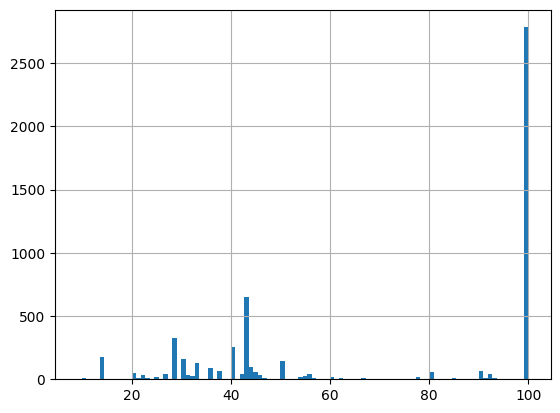

In [14]:
import matplotlib.pyplot as plt

df_merge.city_match.hist(bins=100)
plt.show()

In [15]:
# multiple addresses per therapist - get maximum match per therapist (at least one address needs to be correct)
susp_ids = df_merge[['psyreg_therapist_id', 'city_match', 'psyreg_zipCity', 'searchCH_zipcity']].groupby('psyreg_therapist_id').agg(match_max=('city_match', 'max')).reset_index()
susp_ids[susp_ids.match_max < 98]

,psyreg_therapist_id,match_max
2,1291,42
4,8261,43
5,10905,43
6,11067,43
10,12966,43
...,...,...
4680,138402,40
4682,138433,30
4683,138434,92
4684,138442,43


As there are multiple addresses per therapist in the psyreg-data but only one in the phonebook-data, we only require one address per therapist to match.

In [16]:
df_susp = df_merge[df_merge.psyreg_therapist_id.isin(susp_ids[susp_ids.match_max < 98].psyreg_therapist_id.values)]
df_susp.reset_index(drop=True, inplace=True)
df_susp[['city_match', 'psyreg_zipCity', 'searchCH_zipcity']]

,city_match,psyreg_zipCity,searchCH_zipcity
0,29,"nan, nan","Genève, 1207"
1,14,"nan, nan","Zollikerberg, 8125"
2,29,"nan, nan","Bern, 3012"
3,14,"nan, nan","Bühler, 9055"
4,22,"Liestal, 4410","Agno, 6982"
...,...,...,...
2305,43,"nan, nan","Nänikon, 8606"
2306,57,"St.Gallen, 9000","Walenstadt, 8880"
2307,44,"Bern, 3006","Meikirch, 3045"
2308,29,"nan, nan","Mendrisio, 6850"


To further check on cantons we load a dataset of zip-codes and cantons to connect them in the phonebook-data.

In [54]:
df_plz = pd.read_csv('data/plz.csv')
df_plz

,plz,City,canton_de,canton_fr,canton_it,Abbr
0,1000,Lausanne,Waadt,Vaud,Vaud,VD
1,1003,Lausanne,Waadt,Vaud,Vaud,VD
2,1004,Lausanne,Waadt,Vaud,Vaud,VD
3,1005,Lausanne,Waadt,Vaud,Vaud,VD
4,1006,Lausanne,Waadt,Vaud,Vaud,VD
...,...,...,...,...,...,...
4115,9652,Neu St. Johann,St. Gallen,Saint-Gall,San Gallo,SG
4116,9655,Stein SG,St. Gallen,Saint-Gall,San Gallo,SG
4117,9656,Alt St. Johann,St. Gallen,Saint-Gall,San Gallo,SG
4118,9657,Unterwasser,St. Gallen,Saint-Gall,San Gallo,SG


drop zip-duplicates

In [55]:
df_plz.drop_duplicates(subset=['plz'], inplace=True)
df_plz

,plz,City,canton_de,canton_fr,canton_it,Abbr
0,1000,Lausanne,Waadt,Vaud,Vaud,VD
1,1003,Lausanne,Waadt,Vaud,Vaud,VD
2,1004,Lausanne,Waadt,Vaud,Vaud,VD
3,1005,Lausanne,Waadt,Vaud,Vaud,VD
4,1006,Lausanne,Waadt,Vaud,Vaud,VD
...,...,...,...,...,...,...
4115,9652,Neu St. Johann,St. Gallen,Saint-Gall,San Gallo,SG
4116,9655,Stein SG,St. Gallen,Saint-Gall,San Gallo,SG
4117,9656,Alt St. Johann,St. Gallen,Saint-Gall,San Gallo,SG
4118,9657,Unterwasser,St. Gallen,Saint-Gall,San Gallo,SG


To join the zip-codes we first need to extraxt the zip-code from the city & zip-code block in the phonebook dataset.

In [19]:
df_susp['searchCH_plz'] = df_susp.searchCH_zipcity.apply(lambda x: int(x[-4:]))
df_susp[['searchCH_plz', 'searchCH_zipcity']]

/var/folders/3p/zn615dls2gv0xhj_cn94h4_h0000gn/T/ipykernel_75880/2049784440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_susp['searchCH_plz'] = df_susp.searchCH_zipcity.apply(lambda x: int(x[-4:]))


,searchCH_plz,searchCH_zipcity
0,1207,"Genève, 1207"
1,8125,"Zollikerberg, 8125"
2,3012,"Bern, 3012"
3,9055,"Bühler, 9055"
4,6982,"Agno, 6982"
...,...,...
2305,8606,"Nänikon, 8606"
2306,8880,"Walenstadt, 8880"
2307,3045,"Meikirch, 3045"
2308,6850,"Mendrisio, 6850"


Merge the zip-codes to the dataframe of suspicious entries.

In [20]:
df_susp_plz = df_susp.merge(df_plz, how='left', left_on='searchCH_plz', right_on='plz')
df_susp_plz

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,...,searchCH_zipcity,searchCH_country,city_match,searchCH_plz,plz,City,canton_de,canton_fr,canton_it,Abbr
0,98527,Laure,Zimmermann,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Genève, 1207",Schweiz,29,1207,1207,Genève,Genf,Genève,Ginevra,GE
1,97172,Vera,Planta,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Zollikerberg, 8125",Schweiz,14,8125,8125,Zollikerberg,Zürich,Zurich,Zurigo,ZH
2,114541,Gerda,Mastronardi-Johner,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Bern, 3012",Schweiz,29,3012,3012,Bern,Bern,Berne,Berna,BE
3,96278,Olivera,Kovacevic,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Bühler, 9055",Schweiz,14,9055,9055,Bühler,Appenzell Ausserrhoden,Appenzell Rhodes-Extérieures,Appenzello Esterno,AR
4,129818,Silvana,Arpagaus,"Psychiatrie Baselland, Abulatorien und Tageskl...",NaN,NaN,Spitalstrasse 1,"Liestal, 4410",4410.0,Liestal,...,"Agno, 6982",Schweiz,22,6982,6982,Agno,Tessin,Tessin,Ticino,TI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,114558,Eliane,Müller,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Nänikon, 8606",Schweiz,43,8606,8606,Nänikon,Zürich,Zurich,Zurigo,ZH
2306,113223,Tamara,Ackermann,Psychotherapie Ackermann,NaN,NaN,Spisergasse 3,"St.Gallen, 9000",9000.0,St.Gallen,...,"Walenstadt, 8880",Schweiz,57,8880,8880,Walenstadt,St. Gallen,Saint-Gall,San Gallo,SG
2307,96275,Nina,Konrad,Psychologische Psychotherapie N. Konrad GmbH,NaN,NaN,Thunstrasse 93,"Bern, 3006",3006.0,Bern,...,"Meikirch, 3045",Schweiz,44,3045,3045,Meikirch,Bern,Berne,Berna,BE
2308,105327,Liliana,Waelchli Ferrario,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,"Mendrisio, 6850",Schweiz,29,6850,6850,Mendrisio,Tessin,Tessin,Ticino,TI


Check which cantons match.

In [21]:
df_susp_plz['canton_match'] = df_susp_plz['psyreg_canton'] == df_susp_plz['canton_de']
df_susp_plz[['psyreg_canton', 'canton_de', 'canton_match']]

,psyreg_canton,canton_de,canton_match
0,Genf,Genf,True
1,Bern,Zürich,False
2,Bern,Bern,True
3,Zug,Appenzell Ausserrhoden,False
4,Basel-Land,Tessin,False
...,...,...,...
2305,Bern,Zürich,False
2306,St. Gallen,St. Gallen,True
2307,Bern,Bern,True
2308,Tessin,Tessin,True


In [22]:
df_susp_plz_canton = df_susp_plz[~df_susp_plz.canton_match]
df_susp_plz_canton

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,...,searchCH_country,city_match,searchCH_plz,plz,City,canton_de,canton_fr,canton_it,Abbr,canton_match
1,97172,Vera,Planta,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,Schweiz,14,8125,8125,Zollikerberg,Zürich,Zurich,Zurigo,ZH,False
3,96278,Olivera,Kovacevic,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,Schweiz,14,9055,9055,Bühler,Appenzell Ausserrhoden,Appenzell Rhodes-Extérieures,Appenzello Esterno,AR,False
4,129818,Silvana,Arpagaus,"Psychiatrie Baselland, Abulatorien und Tageskl...",NaN,NaN,Spitalstrasse 1,"Liestal, 4410",4410.0,Liestal,...,Schweiz,22,6982,6982,Agno,Tessin,Tessin,Ticino,TI,False
6,86725,Nadia,Kohler,Praxisgemeinschaft Steinenberg,NaN,NaN,Steinenberg 5,"Basel, 4051",4051.0,Basel,...,Schweiz,40,5610,5610,Wohlen AG,Aargau,Argovie,Argovia,AG,False
7,86725,Nadia,Kohler,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,Schweiz,29,5610,5610,Wohlen AG,Aargau,Argovie,Argovia,AG,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,97143,Susanne,Pignalosa-Seiler,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,Schweiz,14,3185,3185,Schmitten FR,Freiburg,Fribourg,Friburgo,FR,False
2299,114570,Beat,Brauchli,NaN,NaN,NaN,NaN,"nan, nan",NaN,NaN,...,Schweiz,43,8606,8606,Nänikon,Zürich,Zurich,Zurigo,ZH,False
2303,130388,Nathalie,à Porta,-,NaN,NaN,Schweizergasse 6,"Zürich, 8001",8001.0,Zürich,...,Schweiz,30,2740,2740,Moutier,Bern,Berne,Berna,BE,False
2304,118362,Daniel,Christen,daniel Christen,NaN,NaN,Rue de la Fontaine 10,"Paudex, 1094",1094.0,Paudex,...,Schweiz,45,1224,1224,Chêne-Bougeries,Genf,Genève,Ginevra,GE,False


We further remove therapists without address as we can obviously not review them.

In [51]:
df_out = df_susp_plz_canton[df_susp_plz_canton.psyreg_city.notna()]
df_out.reset_index(drop=True, inplace=True)
df_out

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,...,searchCH_country,city_match,searchCH_plz,plz,City,canton_de,canton_fr,canton_it,Abbr,canton_match
0,129818,Silvana,Arpagaus,"Psychiatrie Baselland, Abulatorien und Tageskl...",NaN,NaN,Spitalstrasse 1,"Liestal, 4410",4410.0,Liestal,...,Schweiz,22,6982,6982,Agno,Tessin,Tessin,Ticino,TI,False
1,86725,Nadia,Kohler,Praxisgemeinschaft Steinenberg,NaN,NaN,Steinenberg 5,"Basel, 4051",4051.0,Basel,...,Schweiz,40,5610,5610,Wohlen AG,Aargau,Argovie,Argovia,AG,False
2,103001,Nathalie,Rossé,YOUKIDOC AG,NaN,NaN,Güterstrasse 90,"Basel, 4053",4053.0,Basel,...,Schweiz,33,3250,3250,Lyss,Bern,Berne,Berna,BE,False
3,105470,Claudia,Weibel,Klinik Selhofen,NaN,NaN,Emmentalstrasse 8,"Burgdorf, 3401",3401.0,Burgdorf,...,Schweiz,23,5503,5503,Schafisheim,Aargau,Argovie,Argovia,AG,False
4,98282,Aline,Vonlanthen,-,NaN,NaN,Hochstrasse 110,"Zürich, 8044",8044.0,Zürich,...,Schweiz,10,1623,1623,Semsales,Freiburg,Fribourg,Friburgo,FR,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,101182,Thierry,Weidmann,Praxisgemeinschaft Schöntal,NaN,NaN,Schöntalstrasse 21,"Zürich, 8004",8004.0,Zürich,...,Schweiz,20,4055,4055,Basel,Basel-Stadt,Bâle-Ville,Basilea Città,BS,False
613,80359,Louise Marie,Meyer,Les Toises - Centre de psychiatrie et - de psy...,NaN,NaN,Avenue des Mousquines 4,"Lausanne, 1005",1005.0,Lausanne,...,Schweiz,36,8606,8606,Nänikon,Zürich,Zurich,Zurigo,ZH,False
614,112673,Daniela,Häberli,Praxisgemeinschaft,NaN,NaN,Grenzacherstrasse 80,"Basel, 4058",4058.0,Basel,...,Schweiz,40,5420,5420,Ehrendingen,Aargau,Argovie,Argovia,AG,False
615,130388,Nathalie,à Porta,-,NaN,NaN,Schweizergasse 6,"Zürich, 8001",8001.0,Zürich,...,Schweiz,30,2740,2740,Moutier,Bern,Berne,Berna,BE,False


At last we are left with __617 suspicious entries__. At this point, we cannot make any statement as to whether the entries are actually wrongdoers practising in a canton without licence or simply a case of confusion based on the name. But we have exhausted all tools in terms of code and reduced the circle of suspects as much as possible. Now we have to check the rest by hand. To do this, we create a nicely formatted table and save it as a CSV.

In [52]:
df_out.fillna('', inplace=True)
df_out['psyreg_name'] = df_out['psyreg_firstName'] + ' ' + df_out['psyreg_name']
df_out['psyreg_address'] = df_out['psyreg_practiceCompanyName'] + ' '  + df_out['psyreg_addition1'] + ' '  + df_out['psyreg_addition2'] + ' '  + df_out['psyreg_streetWithNumber'] + ', '  + df_out['psyreg_zip'].astype(str) + ' '  + df_out['psyreg_city']
df_out['searchCH_name'] = df_out['searchCH_name_1'] + ', '  + df_out['searchCH_name_2'] 
df_out['searchCH_address'] = df_out['searchCH_street'] + ', '  + df_out['searchCH_zipcity'] 
df_out['psyreg_url'] = df_out.psyreg_therapist_id.apply(lambda x: BASE_URL.format(x))
df_out

/var/folders/3p/zn615dls2gv0xhj_cn94h4_h0000gn/T/ipykernel_75880/3614641971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.fillna('', inplace=True)
/var/folders/3p/zn615dls2gv0xhj_cn94h4_h0000gn/T/ipykernel_75880/3614641971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['psyreg_name'] = df_out['psyreg_firstName'] + ' ' + df_out['psyreg_name']
/var/folders/3p/zn615dls2gv0xhj_cn94h4_h0000gn/T/ipykernel_75880/3614641971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,psyreg_therapist_id,psyreg_firstName,psyreg_name,psyreg_practiceCompanyName,psyreg_addition1,psyreg_addition2,psyreg_streetWithNumber,psyreg_zipCity,psyreg_zip,psyreg_city,...,City,canton_de,canton_fr,canton_it,Abbr,canton_match,psyreg_address,searchCH_name,searchCH_address,psyreg_url
0,129818,Silvana,Silvana Arpagaus,"Psychiatrie Baselland, Abulatorien und Tageskl...",,,Spitalstrasse 1,"Liestal, 4410",4410.0,Liestal,...,Agno,Tessin,Tessin,Ticino,TI,False,"Psychiatrie Baselland, Abulatorien und Tageskl...","Saitta\, Vincenzo e Silvana (-Arpagaus), Saitt...","Via Pestariso 11A, Agno, 6982",https://www.psyreg.admin.ch/psyreg/person/129818
1,86725,Nadia,Nadia Kohler,Praxisgemeinschaft Steinenberg,,,Steinenberg 5,"Basel, 4051",4051.0,Basel,...,Wohlen AG,Aargau,Argovie,Argovia,AG,False,Praxisgemeinschaft Steinenberg Steinenberg 5...,"Caruso Kohler\, Nadia, Caruso Kohler Nadia","Sonnhaldenweg 2A, Wohlen, 5610",https://www.psyreg.admin.ch/psyreg/person/86725
2,103001,Nathalie,Nathalie Rossé,YOUKIDOC AG,,,Güterstrasse 90,"Basel, 4053",4053.0,Basel,...,Lyss,Bern,Berne,Berna,BE,False,"YOUKIDOC AG Güterstrasse 90, 4053.0 Basel","Leenhof,","Bernstrasse 106, Lyss, 3250",https://www.psyreg.admin.ch/psyreg/person/103001
3,105470,Claudia,Claudia Weibel,Klinik Selhofen,,,Emmentalstrasse 8,"Burgdorf, 3401",3401.0,Burgdorf,...,Schafisheim,Aargau,Argovie,Argovia,AG,False,"Klinik Selhofen Emmentalstrasse 8, 3401.0 Bu...","Cosmetic-Studio Ciel,","Kastanienweg 2, Schafisheim, 5503",https://www.psyreg.admin.ch/psyreg/person/105470
4,98282,Aline,Aline Vonlanthen,-,,,Hochstrasse 110,"Zürich, 8044",8044.0,Zürich,...,Semsales,Freiburg,Fribourg,Friburgo,FR,False,"- Hochstrasse 110, 8044.0 Zürich","Vonlanthen\, Marc et Aline, Vonlanthen Marc et...","Les Charmilles 86, Semsales, 1623",https://www.psyreg.admin.ch/psyreg/person/98282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,101182,Thierry,Thierry Weidmann,Praxisgemeinschaft Schöntal,,,Schöntalstrasse 21,"Zürich, 8004",8004.0,Zürich,...,Basel,Basel-Stadt,Bâle-Ville,Basilea Città,BS,False,Praxisgemeinschaft Schöntal Schöntalstrasse ...,"Weidmann\, Thierry, Weidmann Thierry","Palmenstrasse 23, Basel, 4055",https://www.psyreg.admin.ch/psyreg/person/101182
613,80359,Louise Marie,Louise Marie Meyer,Les Toises - Centre de psychiatrie et - de psy...,,,Avenue des Mousquines 4,"Lausanne, 1005",1005.0,Lausanne,...,Nänikon,Zürich,Zurich,Zurigo,ZH,False,Les Toises - Centre de psychiatrie et - de psy...,"Sexualberatung und Paartherapie Lustkreis\, Ol...","Stationsstrasse 57, Nänikon, 8606",https://www.psyreg.admin.ch/psyreg/person/80359
614,112673,Daniela,Daniela Häberli,Praxisgemeinschaft,,,Grenzacherstrasse 80,"Basel, 4058",4058.0,Basel,...,Ehrendingen,Aargau,Argovie,Argovia,AG,False,"Praxisgemeinschaft Grenzacherstrasse 80, 405...","Daniela Häberli,","Birkenstrasse 8, Ehrendingen, 5420",https://www.psyreg.admin.ch/psyreg/person/112673
615,130388,Nathalie,Nathalie à Porta,-,,,Schweizergasse 6,"Zürich, 8001",8001.0,Zürich,...,Moutier,Bern,Berne,Berna,BE,False,"- Schweizergasse 6, 8001.0 Zürich","Au Rendez-Vous avec Soi,","Rue Centrale 47, Moutier, 2740",https://www.psyreg.admin.ch/psyreg/person/130388


In [53]:
df_out[['psyreg_therapist_id', 'psyreg_name', 'psyreg_address', 'searchCH_name', 'searchCH_address', 'searchCH_scrape_url', 'psyreg_url']].to_csv('data/unmatched_addresses.csv', index=False)